In [26]:
# !pip install gradio
# !pip install torch  
# !pip install fastai
# !pip install pytorch-lightning
# !pip install pytorch-lightning-bolts
# !pip install torchvision
# !pip install torchmetrics
# !pip install torchinfo
# !pip install torchsummary
# %pip install numpy

import gradio as gr
import subprocess
import os
import torch
from fastai.vision.all import *
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

FastAI version: 2.7.17
---------------------------------------
/home/lmanov/src/DL_DiabeticRetinopathyStagePrediction/data/raw/mariaherrerot/aptos2019/train_1.csv 
 /home/lmanov/src/DL_DiabeticRetinopathyStagePrediction/data/raw/mariaherrerot/aptos2019/train_images/train_images/
Number of df columns:  2
Number of rows in the dataframe: 2930
img_folder: /home/lmanov/src/DL_DiabeticRetinopathyStagePrediction/data/raw/mariaherrerot/aptos2019/train_images/train_images/
csv_path: /home/lmanov/src/DL_DiabeticRetinopathyStagePrediction/data/raw/mariaherrerot/aptos2019/train_1.csv
Single batch tensor dimensions: torch.Size([8, 3, 224, 224])


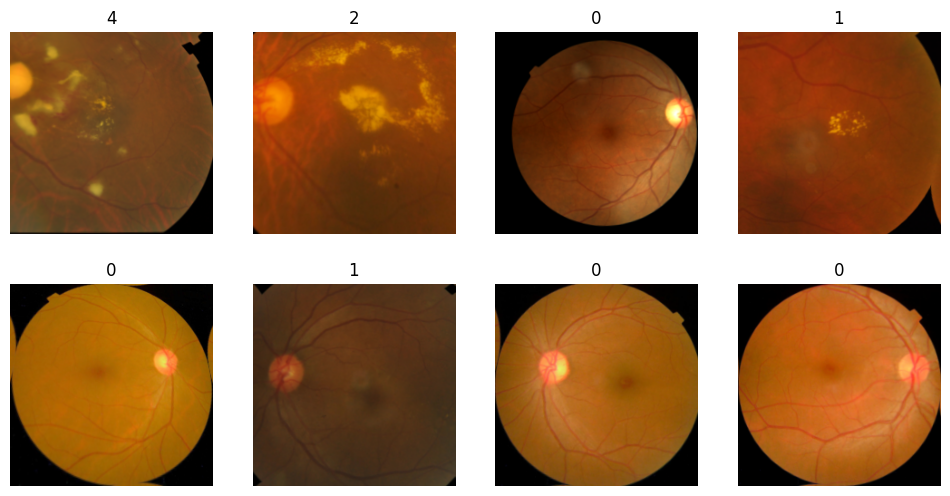

In [27]:
# Load a pre-trained PyTorch model (e.g., ResNet)
import torch.nn as nn
import torchvision.models 
from fastai.vision.all import *
import pandas as pd
from fastai.data.block import DataBlock
from fastai.data.transforms import  RandomSplitter
from fastai.vision.all import DataBlock, ImageBlock, CategoryBlock, ColReader, Resize, aug_transforms 

from sklearn.metrics import precision_score, recall_score, f1_score ,roc_auc_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from fastai.losses import CrossEntropyLossFlat

import fastai
print(f"FastAI version: {fastai.__version__}")


# Load the DataLoaders
import os
import platform
from pathlib import Path
from fastai.vision.all import *

print("---------------------------------------")
path = '/home/lmanov/src/DL_DiabeticRetinopathyStagePrediction/data/raw/mariaherrerot/aptos2019'
csv_path = os.path.join(path.strip(""), 'train_1.csv')
img_folder = str(os.path.join(path, 'train_images/train_images/'))
format  = ".png"
# path = "/home/lmanov/src/DL_DiabeticRetinopathyStagePrediction/data/raw/benjaminwarner/resized-2015-2019-blindness-detection-images"
# csv_path = os.path.join(path.strip(""), 'labels/trainLabels15.csv')
# img_folder = str(os.path.join(path, 'resized train 15/'))
# format  = ".jpg"

print(f"{csv_path} \n {img_folder}")
print("=====================================")



df = pd.read_csv(csv_path)
df[df.columns[0]] = df[df.columns[0]].apply(lambda x: x if x.endswith(format) else x  + format)
df = df[df[df.columns[0]].apply(lambda x: os.path.exists(os.path.join(img_folder, x)))]

print("Number of df columns: ", len(df.columns))
print(f"Number of rows in the dataframe: {len(df)}")
print(f"img_folder: {img_folder}")
print(f"csv_path: {csv_path}")
# Create a DataBlock and DataLoaders
random_splitter=RandomSplitter(valid_pct=0.2, seed=42) 
try:
    dblock = DataBlock(
    blocks=(ImageBlock , CategoryBlock),
    get_x=ColReader(df.columns[0], pref=img_folder),
    get_y=ColReader(df.columns[1]),            
    splitter = random_splitter,     
    item_tfms=Resize(size=224),    
    batch_tfms=aug_transforms(size=224))
except FileNotFoundError:
        print(f"File not found. Skipping to the next file.")
        pass

dls = dblock.dataloaders(df, bs=8, with_labels=True)

dls.show_batch()
batch = dls.one_batch()
print(f"Single batch tensor dimensions: {batch[0].shape}")



In [28]:
# Create a PyTorch Lightning module
# import pytorch_lightning as pl
# import torch.nn.functional as F
# from torch.optim.optimizer import Optimizer

# class FastAIOptimizer(Optimizer):
#     def __init__(self, model , learner):
#         super().__init__(learner.model.parameters(), {})
#         self.learner = learner
#         self.model = model        

#     def step(self, closure=None):
#         # Perform a training step using the FastAI Learner
#         batch, _ = self.learner.dls.one_batch()
#         loss = self.learner.loss_func(self.model(batch[0]), batch[1])
#         loss.backward()
#         self.learner.opt.step()
#         self.learner.opt.zero_grad()
#         return loss.item()
    


# class LightningModel(pl.LightningModule):
#     def __init__(self, model , learner=None):
#         super(LightningModel, self).__init__()
#         self.model = model
#         self.learner = learner

#     def forward(self, x):
#         batch_size, channels, width, height = x.size()   
#         return self.model(x)

#     def training_step(self, batch, batch_idx):
#         images, labels = batch 
#         outputs = self(images) 
#         loss = self.loss_fn(outputs, labels) 
#         self.log('train_loss', loss) 
#         return loss

#     def configure_optimizers(self):
#         optimizer = torch.optim.Adam(self.parameters(), lr=0.001) 
#         return optimizer

In [29]:
# Create a model here

num_classes = len(dls.vocab)
print(f"Number of classes: {num_classes}")
model_name = "resnet18"
model = torchvision.models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)

#model_name = "efficientnet_b7"
# model = models.efficientnet_b7(weights= EfficientNet_B7_Weights.IMAGENET1K_V1)                
# num_ftrs = model.classifier[1].in_features                
# model.classifier[1] = nn.Linear(num_ftrs, num_classes)

# create a model
def load_model(model_name, model , load_from_file=False):
    """
    Load the model from a saved file if it exists, otherwise return the newly created model.
    
    Parameters:
    model_name (str): The name of the model.
    model (torch.nn.Module): The newly created model.
    
    Returns:
    torch.nn.Module: The loaded or newly created model.
    """
    Loaded_from_file = False
    if load_from_file == True:
        model_file = model_name + ".pth"
        if os.path.exists(model_file):
            model = torch.load(model_file)
            print(f"Loaded model from {model_file}")
            Loaded_from_file = True
        else:
            print(f"No saved model found at {model_file}, using the newly created model")

    return model , Loaded_from_file



Number of classes: 5


/home/lmanov/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lmanov/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Create a module and load stored weights (from file) - or fine tune otherwise    
Pay attention , here we pass a tensorboard callback object to Fast AI's fine_tune  , to gather training data  like losses, accuracy , so on 

In [32]:

from fastai.callback.tensorboard import TensorBoardCallback

# Create a FastAI Learner object and fine-tune the model
model , Loaded_from_file  = load_model(model_name, model , load_from_file= False) 

%rm -rf ./logs
%rm -rf ./runs
datetimestr = datetime.now().strftime("%Y%m%d-%H%M%S")
logdir="logs/fine_tune/" + model_name + '/' + datetimestr

tbcallbacks = None
if Loaded_from_file == False:
    tbcallbacks = [TensorBoardCallback(log_dir=logdir )]
learn = Learner(dls, model,
                loss_func=CrossEntropyLossFlat(),              
                metrics=[accuracy], 
                cbs=tbcallbacks )

if Loaded_from_file == False:
    learn.fine_tune(6)
    torch.save(model, model_name + ".pth")



epoch,train_loss,valid_loss,accuracy,time
0,0.717775,1.044928,0.663823,01:38


epoch,train_loss,valid_loss,accuracy,time
0,0.588012,0.642473,0.764505,01:43
1,0.629698,0.656301,0.774744,01:46
2,0.635935,0.592228,0.779863,01:45
3,0.564229,0.588959,0.790102,01:46
4,0.503976,0.566008,0.796928,01:46
5,0.459234,0.552748,0.802048,01:55


In [ ]:
#!pip install torchviz
import torch 
#import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchviz import make_dot 
import tensorflow as tf 
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import itertools
from fastai.vision.core import PILImage
from packaging import version
import tensorboard as tb

print(f"TensorFlow version: {tf.__version__}")
print(f"PyTorch version: {torch.__version__}")
major_ver, minor_ver, _ = version.parse(tb.__version__).release
print("TensorBoard version: ", tb.__version__)

class_names = ['No DR', 'Mild DR', 'Moderate DR', 'Severe DR', 'Proliferative DR'] 

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues, tensorboard_writer=None):
    fig_cm, ax = plt.subplots(figsize=(8, 8))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            text = f"{cm[i, j]:.2f}"
        else:
            text = f"{int(cm[i, j])}"
        plt.text(j, i, text, horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
        
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()    
    plt.show()
    if tensorboard_writer:
        tensorboard_writer.add_figure(title, fig_cm)
    return fig_cm


def plot_roc_auc(class_names , targets, preds, tensorboard_writer):
        # ROC and AUC for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(targets == i, preds == i)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    fig_roc, ax = plt.subplots(figsize=(10, 8))
    for i in range(len(class_names)):
        ax.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic')
    ax.legend(loc='lower right')
    
    plt.tight_layout()
    plt.show()
    if tensorboard_writer:
        tensorboard_writer.add_figure('ROC Curves', fig_roc)
    return fig_roc



# Function to plot sample predictions
def plot_sample_predictions(dls, preds, targets, img_path='' , tensorboard_writer= writer):
    """
    Plot sample predictions for FastAI vision classification
    
    Parameters:
    dls: FastAI DataLoaders
    preds: Model predictions
    targets: True labels
    img_path: Base path to the images directory (if needed)
    """
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()
    
    # Get the first 10 items from validation dataset
    items = dls.valid_ds.items[:10]
    for i, (item, pred, target) in enumerate(zip(items.itertuples(), preds[:10], targets[:10])):
        try:
            # Construct full image path
            img_filename = item.id_code            
            if img_path:
                full_path = os.path.join(img_path, img_filename)
            else:
                full_path = img_filename
                
            # Load and display image
            img = Image.open(full_path)
            axes[i].imshow(img)
            axes[i].set_title(f'True: {class_names[target]}\nPred: {class_names[pred]}')
            axes[i].axis('off')
            
        except Exception as e:
            print(f"Error processing image {img_filename}: {str(e)}")
            axes[i].text(0.5, 0.5, 'Error loading image', 
                        ha='center', va='center')
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

    if tensorboard_writer:      
        tensorboard_writer.add_figure('Sample Predictions', fig)
    return fig

TensorFlow version: 2.18.0
PyTorch version: 2.2.2+cu121
TensorBoard version:  2.18.0


## Evaluate model and add different metrics to a tensorboard

logs/fine_tune/resnet18/20241109-161953


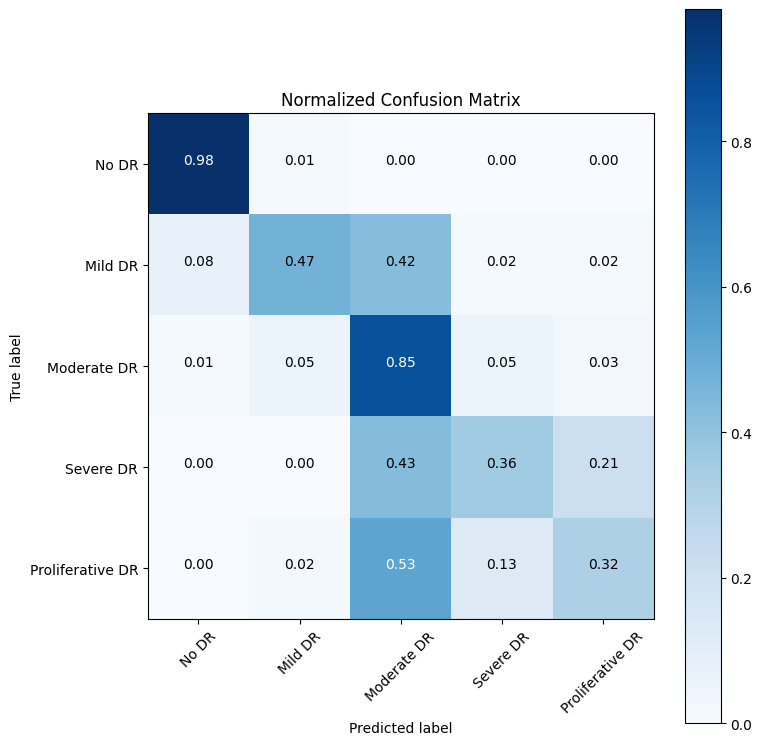

                  precision    recall  f1-score   support

           No DR      0.975     0.982     0.978       276
         Mild DR      0.689     0.470     0.559        66
     Moderate DR      0.686     0.852     0.760       169
       Severe DR      0.385     0.357     0.370        28
Proliferative DR      0.556     0.319     0.405        47

        accuracy                          0.804       586
       macro avg      0.658     0.596     0.615       586
    weighted avg      0.797     0.804     0.793       586

{'No DR': {'precision': 0.9748201438848921, 'recall': 0.9818840579710145, 'f1-score': 0.9783393501805054, 'support': 276.0}, 'Mild DR': {'precision': 0.6888888888888889, 'recall': 0.4696969696969697, 'f1-score': 0.5585585585585585, 'support': 66.0}, 'Moderate DR': {'precision': 0.6857142857142857, 'recall': 0.8520710059171598, 'f1-score': 0.7598944591029023, 'support': 169.0}, 'Severe DR': {'precision': 0.38461538461538464, 'recall': 0.35714285714285715, 'f1-score': 0.37

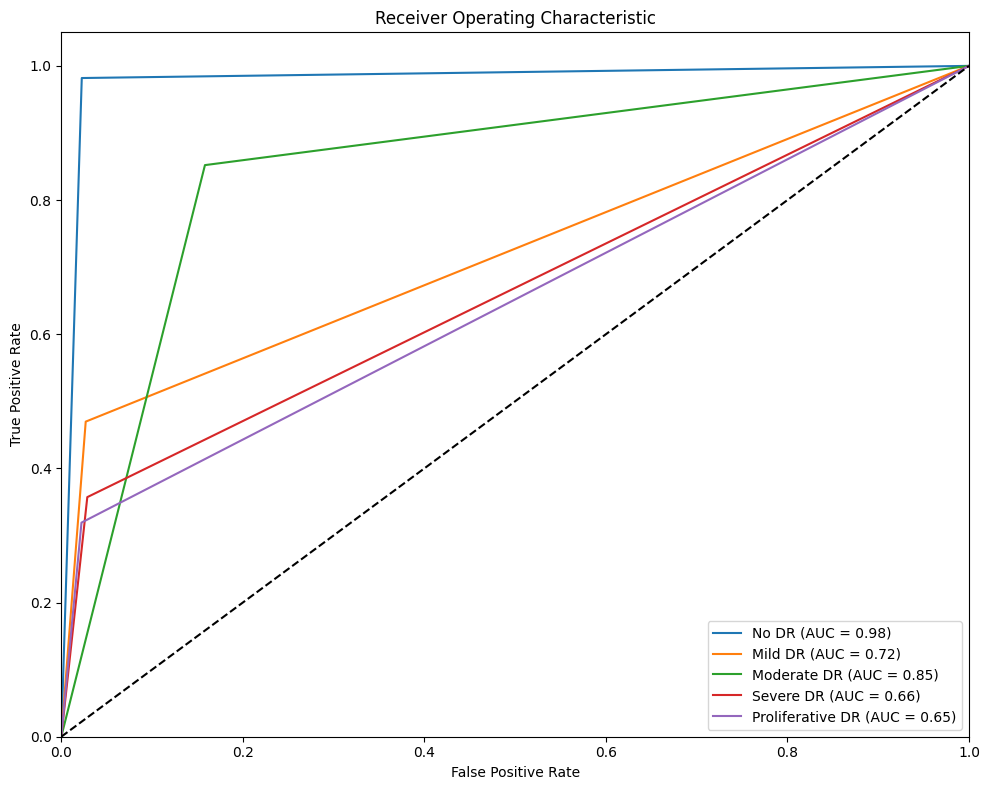

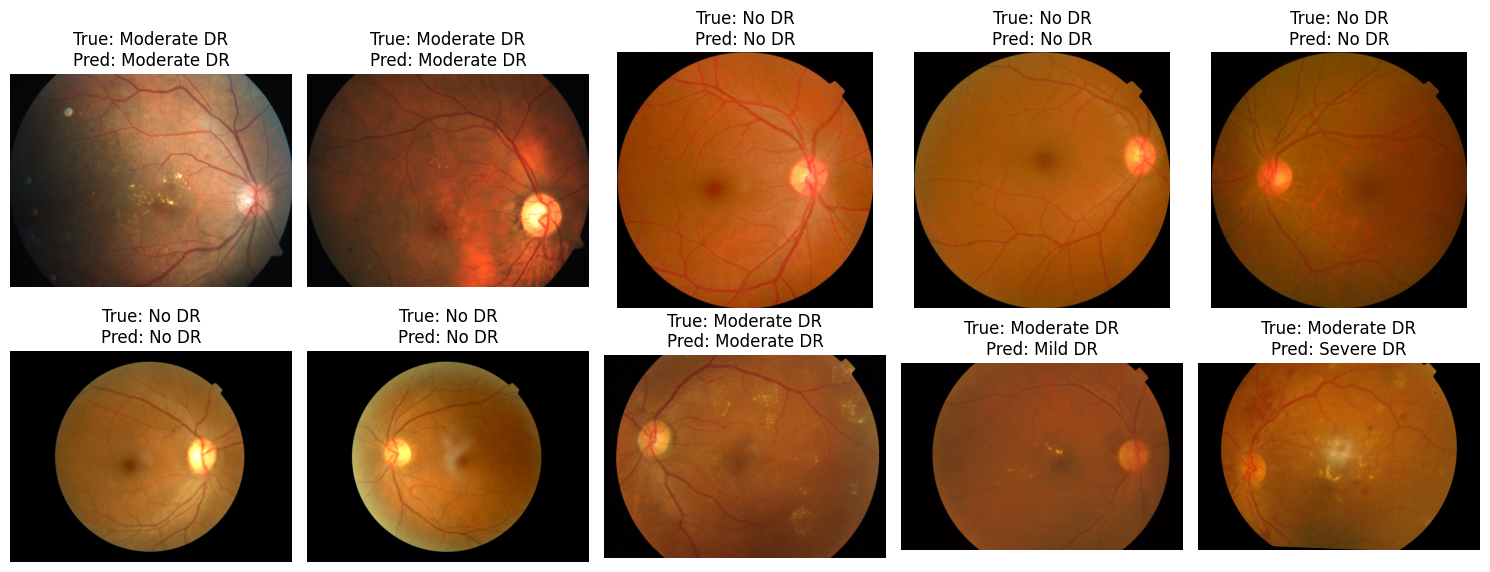

In [ ]:


batch = dls.one_batch()
# Forward pass through the model 
output = model(batch[0])

# Create a SummaryWriter 
writer = SummaryWriter('logs/eval/' + model_name + '/' + datetimestr)
# Add the model graph to TensorBoard 
writer.add_graph(model, (batch[0]))

# Create a visualization of the model 
dot = make_dot(output, params=dict(model.named_parameters()), show_attrs=True, show_saved=True)
graph_file_name = model_name + '_model_graph'
dot.render(graph_file_name, format="png")

# torchvision_graph_file = graph_file_name + '.png'
# writer.add_image('Model Graph', torchvision_graph_file)

# Get predictions and true labels
preds, targets = learn.get_preds(dl=dls.valid)
preds = np.argmax(preds, axis=1)
targets = targets.numpy()

# Confusion matrix
cm = confusion_matrix(targets, preds)

# Plot confusion matrix
plot_confusion_matrix(cm, classes=class_names, normalize=True, title='Normalized Confusion Matrix', tensorboard_writer= writer)


# Convert targets and predictions to numpy arrays if they aren't already
targets = np.array(targets)
preds = np.array(preds)

# Generate the classification report
report_text = classification_report(
    y_true=targets,
    y_pred=preds,
    target_names=class_names,
    digits=3
)

print(report_text)
writer.add_text('Classification Report', report_text)


# Classification report
report = classification_report(targets, preds, target_names=class_names, output_dict=True)
print(report)


plot_roc_auc(class_names , targets, preds ,tensorboard_writer= writer)


# Log Precision, Recall, F1-score, and Accuracy
for label, metrics in report.items():
    if label == 'accuracy':
        writer.add_scalar(f'Accuracy', metrics, 1)
    else:
        for metric_name, value in metrics.items():
            writer.add_scalar(f'{label}/{metric_name.capitalize()}', value, 1)

# Plot and log sample predictions
fig_preds = plot_sample_predictions(dls, preds, targets, img_folder, tensorboard_writer= writer)
writer.add_figure('Sample Predictions', fig_preds)

writer.close()

# print(model.eval())
# # Plot the resnet_model_graph
# img = mpimg.imread(graph_file_name + '.png')
# plt.figure(figsize=(10, 10))
# plt.imshow(img)
# plt.axis('off')
# plt.show()

# Start TensorBoard 
%tensorboard --logdir tb_logs
